---
title: NIGnet - Neural Injective Geometry network
subtitle: Theory to Practice - A Tutorial on NIGnet representation.
date: 2025-10-15
bibliography:
  - references.bib
---

Neural Injective Geometry network (NIGnet) is a neural architecture proposed by
[@atharvaaalok_nignets]. It is a specially designed neural network architecture that is invertible
and therefore provides a way of representing only non-self-intersecting geometry. We do this by
using a Pre-Aux net with the NIGnet architecture. In this tutorial, we walk through the theory
behind the NIGNet representation and how to actually use their `geodiff` implementation in practice.

In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import torch

from geodiff.aux_nets import PreAuxNet
from geodiff.nig_net import NIGnet
from geodiff.monotonic_nets import SmoothMinMaxNet
from geodiff.loss_functions.chamfer import ChamferLoss

from assets.utils import square, normalize_0_to_1


# Set the seed for reproducibility
torch.manual_seed(42)

## Theoretical Background
The NIGnet architecture as proposed in [@atharvaaalok_nignets] is based on the idea of stacking
simple nonlinear invertible transformations. Computing the inverse and the determinant of the
Jacobian is useful for log-likelihood training of generative models (of say images) but we do not
require these properties and are only interested in the architecture being guaranteed invertible.
That is, as long as we are concerned we only need a guarantee on the transformation represented by
the network being invertible we will never actually want to invert it or compute the Jacobian of the
determinant. Therefore, we only focus on the `forward` pass of the network and do not discuss the
computations of the inverse or the determinant of the Jacobian.

The NIGnet architecture is composed of bijective transformations that serve as a building block for
the entire transformation `f`. In particular, it uses linear layers followed by monotonic networks
as the building block defined as follows:

**Linear layer:** To guarantee that the linear layers are invertible we use the matrix exponential.
:::{math}
:label: exp_linear_layer
\begin{align*}
&W \in \mathbb{R}^{2 \times 2} \\
&A = e^{W} \\
&y = Ax
\end{align*}
:::
Since the matrix exponential returns an invertible matrix for any weight matrix $W$, we can run
unconstrained optimization on $W$ while guaranteeing non-self-intersection.

**Monotonic layer:** Let $x \in \mathbb{R}^{D}$ with its elements denoted by $x_i$ and $m$ be a
monotonic function defined on $\mathbb{R}$. The monotonic function is parameterized by a monotonic
network and replaces the activation functions usually used in neural networks. Let $y$ denote the
output of the monotonic layer with its elements denoted by $y_i$. Then we have:
:::{math}
:label: monotonic_layer
y_i = m(x_i) \qquad i = {1, \ldots, D}
:::

## Implementation using `geodiff`
We now look at how `geodiff` allows us to easily use the NIGnet parameterization to represent
shapes.

The NIGnet class initializer and its expected arguments are shown below:
:::{literalinclude} ../src/geodiff/nig_net.py
:start-at: __init__
:end-at: -> None
:::

To construct a NIGnet object, we need to supply:
- **Geometry Dimension** 2 for 2D and 3 for 3D.
- **Layer Count** the number of layers in the NIGnet architecture.
- **Monotonic Net** a torch network module to be used as the monotonic network.
- **Pre-Aux Net** parameters such as layer count, hidden dimension, activation, normalization and
    output functions.
- **Boolean Flags** for using batch normalization and residual connections with the NIGnet layers.
- **Intersection Mode** to decide whether to use a Linear layer (possible intersection) or an
    ExpLinear layer (impossible intersection).

### Fitting Shapes
We will use a square as our target geometry. We then use the `ChamferLoss` to compute the geometric
difference loss between the target shape and the shape represented by our NIGnet parameterization.
Since the implementation is written in PyTorch we can use the autograd capabilities to compute the
gradients of the loss w.r.t. the NIGnet network parameters and use an optimizer to modify our
geometry.

We start by obtaining points on our shapes and normalizing them appropriately such that
$x \in [0, 1]$. This is not needed for NIGnet but is used to offer a comparison with the classical
shape representation methods like Hicks-Henne and CST.

In [2]:
# Get points on a square (curve to fit)
num_pts = 1000
X_square = square(num_pts)

# Normalize x values to the range [0, 1] to compare with other representation methods
X_square = normalize_0_to_1(X_square)

We now create a `NIGnet` object by specifying the geometry dimension, layer count, monotonic network
and Pre-Aux net parameters.

In [3]:
# Create a NIGnet object
# First create Pre-Aux and monotonic networks to pass to the NIGnet initializer
preaux_net = PreAuxNet(geometry_dim = 2, layer_count = 2, hidden_dim = 20)
monotonic_net = SmoothMinMaxNet(input_dim = 1, n_groups = 6, nodes_per_group = 6)
nig_net = NIGnet(
    geometry_dim = 2,
    layer_count = 4,
    preaux_net = preaux_net,
    monotonic_net = monotonic_net,
)

We use the `ChamferLoss` provided by `geodiff` to compute a geometric loss between the target shape
and the shape represented by the `NIGnet` object. PyTorch's autograd capabilities then allow us to
compute gradients of the loss w.r.t. the NIGnet network parameters and modify them to fit the target
shape.

In [4]:
# Train the NIGnet parameters to fit the square
loss_fn = ChamferLoss()

learning_rate = 0.01
epochs = 1000
print_cost_every = 200

Y_train = X_square

optimizer = torch.optim.Adam(nig_net.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.99)

for epoch in range(epochs):
    Y_model = nig_net(num_pts = num_pts)
    
    loss = loss_fn(Y_model, Y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())

    if epoch == 0 or (epoch + 1) % print_cost_every == 0:
        num_digits = len(str(epochs))
        print(f'Epoch: [{epoch + 1:{num_digits}}/{epochs}]. Loss: {loss.item():11.6f}')

Epoch: [   1/1000]. Loss:    0.400921
Epoch: [ 200/1000]. Loss:    0.003428
Epoch: [ 400/1000]. Loss:    0.000974
Epoch: [ 600/1000]. Loss:    0.000243
Epoch: [ 800/1000]. Loss:    0.000100
Epoch: [1000/1000]. Loss:    0.000053


We can now visualize the shape represented by our `NIGnet` object using its `visualize` method.

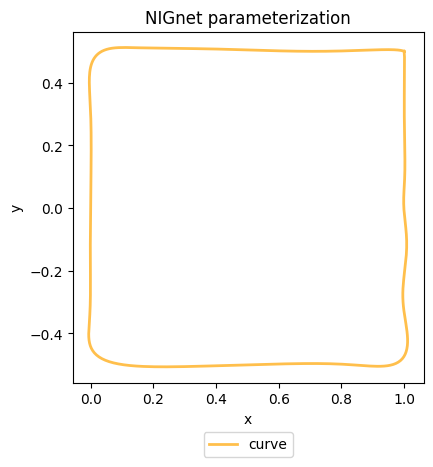

In [5]:
# Visualize the fitted NIGnet shape
fig, ax = nig_net.visualize(num_pts = num_pts)
plt.tight_layout()
plt.show()